# La malaria

Como introducción vamos a hablar brevemente de lo que es la **malaria** o **paludismo**:<br><br>
Es una enfermedad producida por parásitos del género **Plasmodium**. Se piensa que pudo haberse transmitido al ser humano a través de los gorilas occidentales y genera entre 700 000 y 2 700 000 muertes humanas al año.<br><br>
Los vectores de esta enfermedad son las hembras de los mosquitos del género **Anopheles**. Los machos no pican, pues se alimentan de néctares. Las dos únicas formas posibles de contagio directo entre humanos son:
- que una mujer embarazada lo transmita por vía placentaria al feto
- por transfusiones sanguíneas de donantes que han padecido la enfermedad.

# Datos

La base de datos esta formada por 27 558 imágenes de células tras haber aplicado la tinción de Giemsa.<br><br>
Este conjunto de datos puede encontrarse en la página oficial de NIH, en el siguiente enlace: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

# Importación de librerias

Al estar el problema basado en imágenes, vamos a utilizar la librería cv2, con la cual se cargarán los datos en el formato deseado y, se generarás nuevas imágenes de entrenamiento a través de la técnica *data augmentation* realizando transformaciones sobre el set original de entrenamiento en forma de rotaciones.<br><br>
Por otro lado, el problema se va a resolver aplicando una red neuronal convolucional mediante **Keras**.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import initializers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

Using TensorFlow backend.
/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ignacio/MLbook/env_ml/lib/python3.6

## Preparación de los datos

Accedemos a la ruta de las carpetas donde se encuentran las células de ambas clases y generamos dos listas separas

In [2]:
cell_images_path=os.path.join(os.path.join(os.getcwd(), 'datasets'), 'cell_images')
parasitized_path=cell_images_path+'/Parasitized'
uninfected_path=cell_images_path+'/Uninfected'

In [3]:
parasitized_folder=os.listdir(parasitized_path)
uninfected_folder=os.listdir(uninfected_path)

Generamos nuestras listas X e y cargando las imágenes a la par de sus respectivas etiquetas.

Establecemos una dimensión común para hacer posible la entrada de datos posterior a la red neuronal.

El parámetro **cv2.IMREAD_COLOR** nos permite cargar las imágenes ignorando el canal alfa (transparencia). Dando lugar entonces a matrices con solo los canales RGB. Como apunte, cv2 incorpora dos alternativas:

- IMREAD_GRAYSCALE: carga las imagenes en escala de grises
- IMREAD_UNCHANGED: carga las imágenes incluyendo el canal alfa 

In [4]:
X=[]
y=[]
dim=(128,128)
count=0
for image in parasitized_folder:
    try:
        image=cv2.imread(parasitized_path+os.sep+image, cv2.IMREAD_COLOR)
        image=cv2.resize(image, dim)
        X.append(image)
        y.append('Infected')
    except:
        continue
for image in uninfected_folder:
    try:
        image=cv2.imread(uninfected_path+os.sep+image, cv2.IMREAD_COLOR)
        image=cv2.resize(image, dim)
        X.append(image)
        y.append('Uninfected')
    except:
        continue

Tenemos una distribucion de clases completamente simétrica

Number of infected: 13779
Number of uninfected: 13779


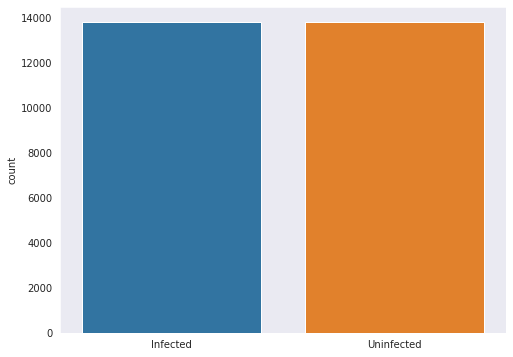

In [5]:
target=pd.Series(y, name='target')
print('Number of infected: {}'.format(target.value_counts()[0]))
print('Number of uninfected: {}'.format(target.value_counts()[1]))

figure=plt.figure(figsize=(8,6))
g1=sns.countplot(x=target)
g1.set_xticklabels(['Infected', 'Uninfected']);
g1.set_xlabel('');

In [6]:
X=np.array(X)
y=np.array(y)

In [7]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test=train_test_split(X, y.astype(np.int8), test_size=0.2, random_state=42)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22046, 128, 128, 3), (22046,), (5512, 128, 128, 3), (5512,))

Mostramos de manera aleatoria como son algunas de las células con sus respectivas etiquetas, dandonos una idea del
nivel de complejidad del problema de clasificación, lo a a determinar la **profundidad** de nuestra red convolucional.

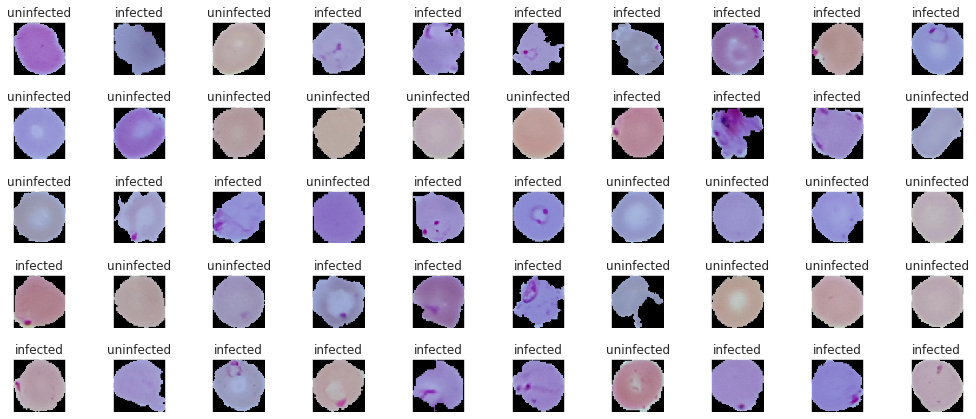

In [10]:
figure, ax=plt.subplots(5,10, figsize=(14,6))
plt.tight_layout()
for row in range(5):
    for col in range(10):
        num=np.random.randint(len(X_train))
        ax[row, col].imshow(X_train[num])
        ax[row, col].tick_params(labelleft=False,labelbottom=False)
        if y[num]==1:
            ax[row,col].set_title('uninfected')
        else:
            ax[row,col].set_title('infected')
            




    
    

Antes de llevar a cabo el aumento del numero de datos de entrenamiento, vamos a ver un ejemplo de como funciona:

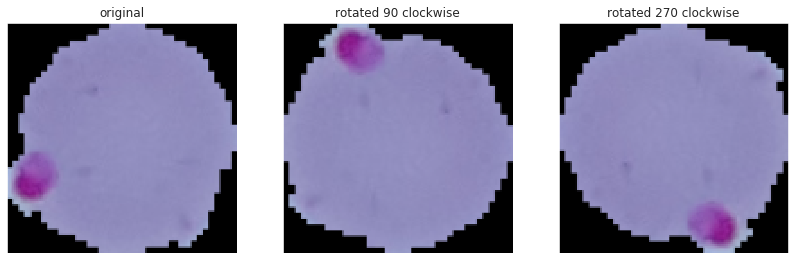

In [11]:
figure, ax=plt.subplots(1,3,figsize=(14,6))
ax[0].imshow(X_train[0])
ax[0].tick_params(labelleft=False,labelbottom=False)
ax[0].set_title('original');

ax[1].imshow(cv2.rotate(X_train[0], cv2.ROTATE_90_CLOCKWISE))
ax[1].tick_params(labelleft=False,labelbottom=False)
ax[1].set_title('rotated 90 clockwise');

ax[2].imshow(cv2.rotate(X_train[0], cv2.ROTATE_90_COUNTERCLOCKWISE))
ax[2].tick_params(labelleft=False,labelbottom=False)
ax[2].set_title('rotated 270 clockwise');



Se van añadiendo a los nuevos vectores *numpy* aumentados X e y las nuevas imágenes una vez rotadas. La excepción de memoria la implemento por si se diera el caso de que el ordenador no aguantase tal cantidad de información en memoria

In [12]:
def data_augmentation(X_train, y_train):
    X_train_augmentated=np.copy(X_train)
    y_train_augmentated=np.copy(y_train)
    for _ in range(0, len(X_train)):
        try: 
            X_train_augmentated=np.concatenate((X_train_augmentated, np.array([cv2.rotate(X_train[_], cv2.ROTATE_90_CLOCKWISE)]), np.array([cv2.rotate(X_train[_], cv2.ROTATE_90_COUNTERCLOCKWISE)])), axis=0)
            y_train_augmentated=np.concatenate((y_train_augmentated, np.array([y_train[_]]),np.array([y_train[_]])), axis=0)
        except MemoryError:
            return (X_train_augmentated, y_train_augmentated)    
    return (X_train_augmentated, y_train_augmentated)

Podemos ver como la cantidad de tiempo de computo es bastante elevada, lo cual era de esperar teniendo en cuenta el volumen de datos y a cantidad de accesos a memoria que deben realizarse.

La última línea de código puede ser útil para generar una señal de alarma que nos avise una vez se haya terminado de ejecutar la función.


In [13]:
import time
begin=time.time()
X_train_augmentated, y_train_augmentated=data_augmentation(X_train,y_train)
print(f'{int(time.time()-begin)}')
duration = 1  # seconds
freq = 2500  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

7922


0

Vemos que efectivamente hemos multiplicado por 3 el volumen de datos de entrenamiento, lo que sin duda hará mejorar el rendimiento de nuestro modelo clasificador.

In [14]:
X_train_augmentated.shape, y_train_augmentated.shape, X_train.shape, y_train.shape


((66138, 128, 128, 3), (66138,), (22046, 128, 128, 3), (22046,))

Vamos a diseñar la estructura de nuestra red neuronal, una red sencilla pero con un rendimiento bueno para este problema concreto.

Usamos 3 sucesivas capas de convolución con sus respectivos *pooling* y *dropout* para regularizar el modelo. El tamaño del kernel es el mismo para todas, su campo de recepción nos permite captar con suficiente precisión las características locales de la imagen. Combinando los valores de paso (*stride*), *padding* nulo y tamaño de kernel vamos reduciendo la dimensión de las imágenes resultantes, hecho que se compensa con el número de filtros por capa. El número de filtros por capa se va duplicando, técnica comunmente usada en diferentes modelos reconocidos de redes neuronales convolucionales, respetando el modelo jerárquico de la red.

Por último se añaden 3 capas completamente conectadas para terminar con una capa de una sola neurona con función de activación sigmoide, ya que estamos ante un problema de clasificación binaria

In [15]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="valid", activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)     

Por último compilamos el modelo estableciendo el optimizador de tipo *adam*. Existen otras alternativas como *sdg*
que pueden, según el caso, generalizar mejor, aunque trabaja más rápido. Una buena opción sería probar ambos optimizadores
y comparar resultados para este problema. 

La función de coste empleada es *binary crossentropy*. En problemas de clasificación binaria existen más opciones, como la función *hinge*. En caso de usar esta función se debe establecer la función de activación de la última neurona 
con la **tangente hiperbólica**, ya que la función de coste trabaja con valores comprendidos en [-1,1]

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Creamos dos funciones callback:
- **Early stopping**: evaluando el valor de la función de coste en el set de validación con una paciencia de 10 **epochs** y valor minimo de mejora de 0.01
- **Model checkpoint**: nos permite guardar el modelo con menor valor de la función de coste en la validación

In [17]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss',  save_best_only=True)

In [18]:
history=model.fit(X_train , y_train , epochs=4000, validation_split=0.2, callbacks=[es, mc])


Train on 17636 samples, validate on 4410 samples
Epoch 1/4000
17636/17636 [==============================] - 279s 16ms/step - loss: 1.0991 - accuracy: 0.5430 - val_loss: 0.6806 - val_accuracy: 0.5914
Epoch 2/4000
17636/17636 [==============================] - 279s 16ms/step - loss: 0.6733 - accuracy: 0.5775 - val_loss: 0.6758 - val_accuracy: 0.6034
Epoch 3/4000
17636/17636 [==============================] - 278s 16ms/step - loss: 0.6604 - accuracy: 0.6072 - val_loss: 0.6454 - val_accuracy: 0.6374
Epoch 4/4000
17636/17636 [==============================] - 278s 16ms/step - loss: 0.6566 - accuracy: 0.6127 - val_loss: 0.6532 - val_accuracy: 0.6354
Epoch 5/4000
17636/17636 [==============================] - 276s 16ms/step - loss: 0.3595 - accuracy: 0.8561 - val_loss: 0.2634 - val_accuracy: 0.8395
Epoch 6/4000
17636/17636 [==============================] - 275s 16ms/step - loss: 0.2011 - accuracy: 0.9329 - val_loss: 0.1685 - val_accuracy: 0.9422
Epoch 7/4000
17636/17636 [==================

Vamos a mostrar mediante grafos la evolución de los valores de precisión y función de coste a lo largo de las diferentes *epochs* tanto para el set de entrenamiento como para el set de validación para visualizar el rendimiento de nuestra red

best epoch: 8
validation accuracy in best epoch: 0.9533
validation loss in best epoch: 0.1475


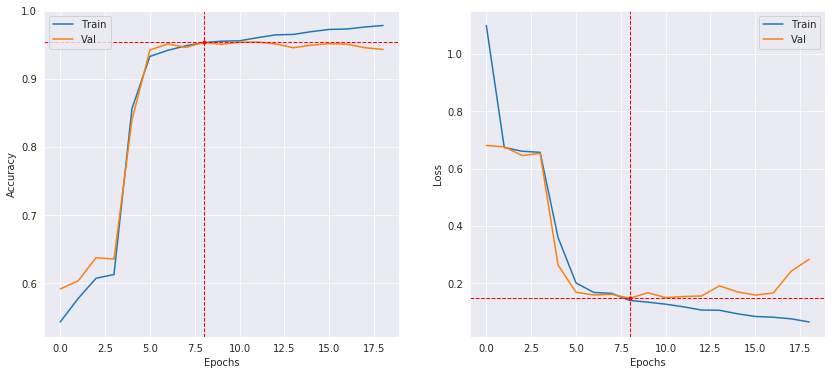

In [19]:
print('best epoch: {}'.format(np.argmin(np.array(history.history['val_loss']))))
print('validation accuracy in best epoch: {:.4f}'.format(history.history['val_accuracy'][np.argmin(np.array(history.history['val_loss']))]))
print('validation loss in best epoch: {:.4f}'.format(np.array(history.history['val_loss']).min()))

figure, ax=plt.subplots(1,2, figsize=(14,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'], loc='upper left')
ax[0].plot([np.argmin(np.array(history.history['val_loss']))], [history.history['val_accuracy'][np.argmin(np.array(history.history['val_loss']))]], marker='o', markersize=3, color="red")
ax[0].axhline(history.history['val_accuracy'][np.argmin(np.array(history.history['val_loss']))], ls='--',  linewidth=1,  color='red')
ax[0].axvline(np.argmin(np.array(history.history['val_loss'])), ls='--',  linewidth=1,  color='red')
ax[0].grid(True)

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'], loc='upper right')
ax[1].plot([np.argmin(np.array(history.history['val_loss']))], [np.array(history.history['val_loss']).min()], marker='o', markersize=3, color="red")
ax[1].axhline(np.array(history.history['val_loss']).min(), ls='--',  linewidth=1,  color='red')
ax[1].axvline(np.argmin(np.array(history.history['val_loss'])), ls='--',  linewidth=1,  color='red')
ax[1].grid(True)


In [20]:
from keras.models import load_model
best_model = load_model('best_model.h5')

In [21]:
test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

Por último mostramos un resumen de las medidas de bondad de nuestro modelo clasificador


In [22]:
print('Accuracy in test set: {:.4f}'.format(test_accuracy[1]))

Accuracy in test set: 0.9546


In [30]:
predictions=best_model.predict_classes(X_test)

In [31]:
confusion_matrix(predictions, y_test)

array([[2622,   75],
       [ 175, 2640]])

In [35]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2697
           1       0.97      0.94      0.95      2815

    accuracy                           0.95      5512
   macro avg       0.95      0.96      0.95      5512
weighted avg       0.96      0.95      0.95      5512

